In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
import gym
from IPython.display import HTML

In [14]:
class MazeEnv(gym.Env):
    def __init__(self):
        self.state = 0

    def reset(self):
        self.state = 0
        return self.state
    
    def step(self, action):
        if action == 0:
            self.state -= 3
        elif action ==1:
            self.state += 1
        elif action == 2:
            self.state +=3
        elif action == 3:
            self.state -= 1
        done = False
        if self.state == 8:
            done = True
        return self.state, 1, done, {}

    

# Updata Theta

MLE:

$$
\begin{aligned}
    \hat{\theta} &= \arg\max_{\theta} \prod_{t=0}^{T-1} \pi_{\theta}(a_{t} \mid s_{t}) \\
    &= \arg\max_{\theta} \log \prod_{t=0}^{T-1} \pi_{\theta}(a_{t} \mid s_{t}) \\
    &= \arg\max_{\theta} \sum_{t=0}^{T-1} \log \pi_{\theta}(a_{t} \mid s_{t})
\end{aligned}
$$

Define:

$$N_{sa}=\sum_{t=0}^{T-1}\mathbb{I}(s_t=s\text{ and }a_t=a)$$

$$\mathcal{L}(\theta)=\sum_{t=0}^{T-1}\log \pi_{\theta} (a_t|s_t)$$

Where:
$$\pi(a|s)=\frac{e^{\theta(s,a)}}{\sum_{a^{\prime}}e^{\theta(s,a^{\prime})}}$$
$$\log\pi(a|s)=\theta(s,a)-\log\sum_{a^{\prime}}e^{\theta(s,a^{\prime})}$$

Therefore:
$$\frac{\partial\mathcal{L}}{\partial\theta(s^{\prime},a^{\prime})}=\sum_{s,a}N_{sa}\frac{\partial\log \pi_{\theta}(a|s)}{\partial\theta(s^{\prime},a^{\prime})}$$

$$\frac{\partial\log\pi(a|s)}{\partial\theta(s^{\prime},a^{\prime})}=
\begin{cases}
1-\pi(a^{\prime}|s) & \mathrm{if~}s=s^{\prime}\text{ 且 }a=a^{\prime} \\
-\pi(a^{\prime}|s) & \mathrm{if~}s=s^{\prime}\text{ 且 }a\neq a^{\prime} \\
0 & \mathrm{otherwise} & & 
\end{cases}$$



$$
\begin{aligned}
    \frac{\partial\mathcal{L}}{\partial\theta(s^{\prime},a^{\prime})}
    &=\sum_aN_{s^{\prime}a}\cdot\frac{\partial\log\pi(a|s^{\prime})}{\partial\theta(s^{\prime},a^{\prime})} \\
    &=N_{s^\prime a^\prime}(1-\pi(a^\prime|s^\prime))+\sum_{a\neq a^\prime}N_{s^\prime a}(-\pi(a^\prime|s^\prime)) \\
    &=N_{s^{\prime}a^{\prime}}-\pi(a^{\prime}|s^{\prime})\left(N_{s^{\prime}a^{\prime}}+\sum_{a\neq a^{\prime}}N_{s^{\prime}a}\right)\\
    &=N_{s^{\prime}a^{\prime}}-\pi(a^{\prime}|s^{\prime})\underbrace{\sum_aN_{s^{\prime}a}}_{N_{s^{\prime}}}
\end{aligned}
$$

$$
     \theta^{\prime} = \theta + \eta[N_{s^{\prime}a^{\prime}}-\pi(a^{\prime}|s^{\prime})N_{s^{\prime}a}]
$$

In [24]:
class Agent():
    def __init__(self, eta=0.1):
        self.actions = list(range(4))
        self.eta = eta
        self.theta = np.array([
            [np.nan, 1, 1, np.nan],      #s0
            [np.nan, 1, np.nan, 1],      #s1
            [np.nan, np.nan, 1, 1],      #s2
            [1, np.nan, np.nan, np.nan], #s3
            [np.nan, 1, 1, np.nan],      #s4
            [1, np.nan, np.nan, 1],      #s5
            [np.nan, 1, np.nan, np.nan], #s6
            [1, 1, np.nan, 1],           #s7
        ])
        self.pi = self._softmax_cvt_theta_0_to_pi()

    # Softmax_
    def _softmax_cvt_theta_0_to_pi(self, beta=1.):
        m,n = self.theta.shape
        pi = np.zeros((m,n))
        exp_theta = np.exp(self.theta * beta)
        for r in range(m):
            pi[r,:] = exp_theta[r,:] / np.nansum(exp_theta[r,:])
        return np.nan_to_num(pi)

    def choose_action(self, state):
        action = np.random.choice(self.actions, p=self.pi[state,:])
        return action
    
    def updata_theta(self, trajectory):
        T = len(trajectory) - 1
        m,n = self.theta.shape
        delta_theta = self.theta.copy()
        for i in range(m):
            for j in range(n):
                if not (np.isnan(self.theta[i,j])):
                    sa_i = [sa for sa in trajectory if sa[0] == i]
                    sa_ij = [sa for sa in trajectory if (sa[0] == i and sa[1] == j)]
                    N_i = len(sa_i)
                    N_ij = len(sa_ij)
                    delta_theta[i,j] = (N_ij - self.pi[i,j]*N_i) / T
        self.theta = self.theta + self.eta * delta_theta
        return self.theta
    
    def updata_pi(self):
        self.pi = self._softmax_cvt_theta_0_to_pi()
        return self.pi


In [25]:
env = MazeEnv()
agent = Agent()
TOL = 1e-6

In [26]:

while True:
    state = env.reset()
    trajectory = [[state, np.nan]]
    done = False
    while not done:
        action = agent.choose_action(state)
        trajectory[-1][1] = action
        state, reward, done, _ = env.step(action)
        trajectory.append([state,np.nan])

    # updata theta
    agent.updata_theta(trajectory)
    pi = agent.pi.copy()

    # updata pi
    agent.updata_pi()

    delta = np.sum(np.abs(
        agent.pi - pi
    ))
    print(len(trajectory), delta)
    if delta < TOL:
        break






25 0.026850148128208184
45 0.009149489009867395
43 0.013083067669026893
31 0.015170581263416472
25 0.018692539472445202
57 0.009364622083261054
19 0.01092729670113407
125 0.005933406853189771
41 0.01259767653683902
49 0.01256246454162474
15 0.03528753051795824
37 0.015624348232703589
55 0.004702133307398215
17 0.03061520895547748
25 0.010621361087106151
9 0.03073838630745701
47 0.01090307238055449
151 0.006634909230124719
81 0.007754645383765968
155 0.009058847615825372
63 0.012142859698042185
31 0.015605250917485047
11 0.028828482274113165
63 0.009548166112587575
23 0.011276075837076127
33 0.015125930658790143
47 0.014998485580554666
15 0.024782659363485837
33 0.007678873028291677
63 0.011974017607975063
13 0.024789811122423955
19 0.013915224686098682
17 0.03651649011517738
103 0.00932291519122802
27 0.011328146696125474
73 0.00879855776053734
79 0.009817874646416036
15 0.01699045187565773
49 0.010840401094216967
45 0.015485233242892193
41 0.015159888692584444
15 0.024425512574096753


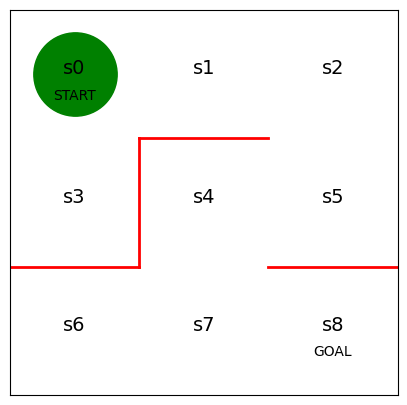

In [27]:
fig = plt.figure(figsize=(5,5))
ax = plt.gca()
ax.set_xlim(0,3)
ax.set_ylim(0,3)

plt.plot([2,3],[1,1], color='red', linewidth=2)
plt.plot([0,1],[1,1], color='red', linewidth=2)
plt.plot([1,1],[1,2], color='red', linewidth=2)
plt.plot([1,2],[2,2], color='red', linewidth=2)

plt.text(0.5, 2.5, 's0', size=14, ha='center')
plt.text(1.5, 2.5, 's1', size=14, ha='center')
plt.text(2.5, 2.5, 's2', size=14, ha='center')
plt.text(0.5, 1.5, 's3', size=14, ha='center')
plt.text(1.5, 1.5, 's4', size=14, ha='center')
plt.text(2.5, 1.5, 's5', size=14, ha='center')
plt.text(0.5, 0.5, 's6', size=14, ha='center')
plt.text(1.5, 0.5, 's7', size=14, ha='center')
plt.text(2.5, 0.5, 's8', size=14, ha='center')
plt.text(0.5, 2.3, 'START', ha='center')
plt.text(2.5, 0.3, 'GOAL', ha='center')
plt.tick_params(
    axis='both', which='both',
    bottom=False, top=False,
    right=False, left=False,
    labelbottom=False, labelleft=False
)
line, = ax.plot([0.5], [2.5], marker='o', color='g', markersize=60)

In [28]:
def init():
    line.set_data([],[])
    return line,
def animate(i):
    state = trajectory[i][0]
    x = [(state % 3) + 0.5]
    y = [2.5 - int(state/3)]
    line.set_data(x,y)

In [29]:
anim = animation.FuncAnimation(
    fig,
    animate,
    frames=len(trajectory),
    init_func=init,
    interval=200,
    repeat=False

)

In [30]:
HTML(anim.to_jshtml())